<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_05_TransferLearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning



In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-05 13:17:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-05 13:17:43 (61.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem



Get the 10% Foor dataset

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-05 13:17:47--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.0MB/s    in 4.5s    

2023-06-05 13:17:52 (35.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Create training and test direcotry paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,

)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent # NONE is insterted due to the batch sie

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.36428566e+01 2.66428566e+01 1.56428576e+01]
   [2.50000000e+01 2.80000000e+01 1.70000000e+01]
   [2.61479588e+01 2.91479588e+01 1.81479588e+01]
   ...
   [4.57140684e+00 6.57140684e+00 1.57140672e+00]
   [4.02551508e+00 6.02551508e+00 1.02551484e+00]
   [5.48470640e+00 7.48470640e+00 2.48470640e+00]]

  [[2.52602043e+01 2.82602043e+01 1.72602043e+01]
   [2.67908173e+01 2.97908173e+01 1.87908173e+01]
   [2.94591846e+01 3.24591827e+01 2.14591846e+01]
   ...
   [3.80104065e+00 5.80104065e+00 8.01040590e-01]
   [4.86223316e+00 6.86223316e+00 1.86223292e+00]
   [2.71425056e+00 4.71425056e+00 4.59157228e-02]]

  [[2.94285717e+01 3.24285736e+01 2.14285717e+01]
   [3.01734695e+01 3.31734695e+01 2.21734695e+01]
   [3.16632652e+01 3.46632652e+01 2.36632652e+01]
   ...
   [5.44901371e+00 7.44901371e+00 2.44901371e+00]
   [6.71427250e+00 8.71427250e+00 3.71427250e+00]
   [4.13774776e+00 6.13774776e+00 1.13774776e+00]]

  ...

  [[4.70914793e+00 1.57091475e+01 1.17091475e+01]
   [4

Keras Sequential vs FUnctional API

* Functional API is more flexible

## Model 0 : Building a transfer learning feature extraction model with Functional API

The sequential API is straight forward, but the functional API Gives us more flexibility with our models

In [9]:
#1. Create the base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(
    include_top=False,

)

# 2. Freeze the base model(the underlying pre-trained patterns aren't modified )

base_model.trainable=False

#3. Create the input into our odel
inputs =  tf.keras.layers.Input(shape=(224,224,3), name='Input layer')

#4. If using Resnet50V2 you will need to normalize inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs to our base model{x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most importantinformation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"shape after global averagepooling2D:{x.shape}")

#7. Create the otput activation layer
outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8 Comibe the inputs with the outputs into a model
model_0=tf.keras.Model(inputs, outputs)

#9 Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
#10. Fit the model and save it's history
istory_10_percent= model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name='10_percent')])




16705208/16705208 [==============================] - 1s 0us/step
shape after passing inputs to our base model(None, 7, 7, 1280)
shape after global averagepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230605-131806


Epoch 1/5
24/24 [==============================] - 22s 272ms/step - loss: 1.8978 - accuracy: 0.4093 - val_loss: 1.3048 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 5s 177ms/step - loss: 1.1003 - accuracy: 0.7667 - val_loss: 0.8904 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 7s 290ms/step - loss: 0.7879 - accuracy: 0.8347 - val_loss: 0.6968 - val_accuracy: 0.8536
Epoch 4/5
24/24 [==============================] - 5s 177ms/step - loss: 0.6471 - accuracy: 0.8440 - val_loss: 0.6066 - val_accuracy: 0.8618
Epoch 5/5
24/24 [==============================] - 6s 214ms/step - loss: 0.5485 - accuracy: 0.8760 - val_loss: 0.5687 - val_accuracy: 0.8684


In [10]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.5596 - accuracy: 0.8616


[0.5595561265945435, 0.8615999817848206]

In [11]:
#Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7ff8a178dba0>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ff8a141a4a0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7ff8a1418220>
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7ff8a1419420>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff8a1419cf0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7ff8a1419e70>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff8a141b490>
7 <keras.layers.core.activation.Activation object at 0x7ff8a141bdf0>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7ff89b884ac0>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff89b885e40>
10 <keras.layers.core.activation.Activation object at 0x7ff89b8869e0>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ff89b8873a0>
12 <keras.l

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

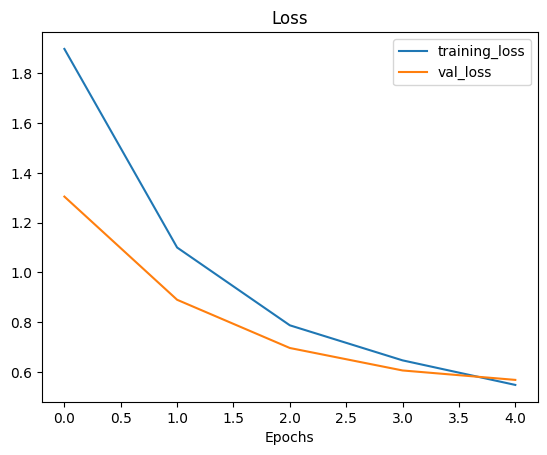

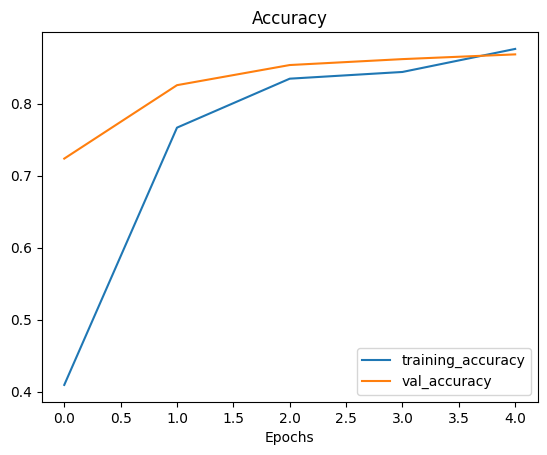

In [14]:
plot_loss_curves(istory_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a ensor after our model goes through 'base model' of shape (None, 7,7 , 1280).

But then it passes through GlobalAveragePooling2D, it turns into (None,1280).

let's use a similar shaped tensor (1,4,4,2) and the pass it through GlobalAverage2D.


In [15]:
input_shape=(1,4,4,3)

#Create a Random Tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print("Random Input Tensor {}".format(input_tensor))



Random Input Tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [16]:
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [17]:
print(global_average_pooled_tensor)

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


In [18]:
print(f"Shape of input tensor{input_tensor.shape} and shapeof averagePooled Tensor{global_average_pooled_tensor.shape}")

Shape of input tensor(1, 4, 4, 3) and shapeof averagePooled Tensor(1, 3)


This is the input to the Output layer

One of the reasons feature extraction transfer learning is named how it is is because what happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample , in our case this is the output of tf.keras.layers.GlobalAveragePooling2D layer which can be then used to extract patterns out of for our own specific problem)

## Running a series of transfer learning experiments

We've seen the incredible results Transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we setup a bunch of experiments to find out

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. 'mode_2' - use feature extraction transfer learning with 10& of the training data with data aith data augmentation

3. 'model_3' - use fine tuning transfer learning with 10% of the training data with Data Augmentation

4. 'model_4'- use fin-tuning transfer learning on 100% of the training data with data augmentation.



## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-06-05 13:19:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  36.2MB/s    in 3.9s    

2023-06-05 13:19:07 (33.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
unzip_data("10_food_classes_1_percent.zip")

In [21]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [22]:
#How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [23]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                               image_size=IMG_SIZE,
                                                                               batch_size=BATCH_SIZE,
                                                                               label_mode='categorical')

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data Augmentation right into the model

TO add data augmentation into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

The benifits of using Data Augmentatio inside the model:
* Preprocessing of images (Augmenting them happens in the GPU)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation with horizontal flipping, rotations, zooms etc

data_augmentations= keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) #Keep for models lile Resnet50V2 but EfficientNet has already built in
], name="data_augmentations")

### Vizualize our data Augmentation Layer and see what happens to our data

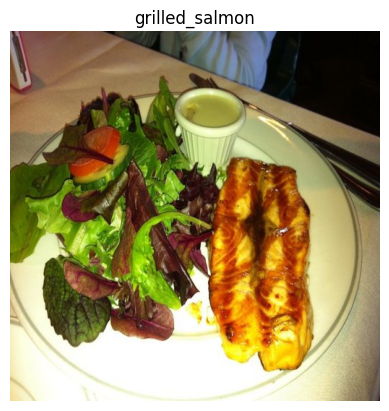

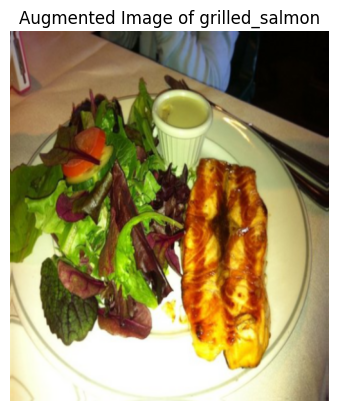

In [25]:
#View a Random Image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" +target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+ random_image

#Read in the random image
img=mpimg.imread(random_image_path)
plt.title(target_class)
plt.axis(False)
plt.imshow(img);

#Now we want to augment that 
augmented_image=data_augmentations(tf.expand_dims(img,axis=0))
plt.figure()
plt.title(f"Augmented Image of {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_image)/255.)

## Model_1: 

In [26]:
#Setup input shape and the base model, freeze the model layers
input_shape=(224,224,3)
IMG_SIZE + (3,)

(224, 224, 3)

In [27]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layers
inputs=layers.Input(shape=input_shape,
                    name='input layer')

#Add in Data Augmentation Sequential model as a layer

x= data_augmentations(inputs)

#Give base model the inputs after they have been augmented and dont train it
x= base_model(x, training=False)

#Pool output features of the base model
x=layers.GlobalAveragePooling2D()(x)

#Put a Dense layer on as a output
outputs=layers.Dense(10,activation='softmax', name='output_layer')(x)

#Make a model using the inputs and outputs
model_1=keras.Model(inputs,outputs)

#Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent=model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback("transfer_learning",
                                                                     experiment_name='1_percent_data_extraction')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_extraction/20230605-131913
Epoch 1/5
3/3 [==============================] - 12s 2s/step - loss: 2.3018 - accuracy: 0.1429 - val_loss: 2.2659 - val_accuracy: 0.1398
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.0845 - accuracy: 0.3143 - val_loss: 2.1292 - val_accuracy: 0.2155
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8766 - accuracy: 0.4286 - val_loss: 2.0387 - val_accuracy: 0.2632
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6910 - accuracy: 0.5000 - val_loss: 1.9184 - val_accuracy: 0.3421
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.5730 - accuracy: 0.6429 - val_loss: 1.8378 - val_accuracy: 0.3865


In [28]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentations (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [29]:
results_1_percent_data_aug=model_1.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 1.8298 - accuracy: 0.3956


How do thr model with 1 % of the data and data augmentation loss curves look like

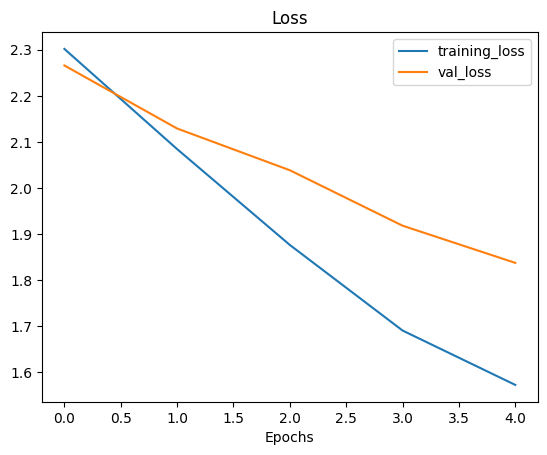

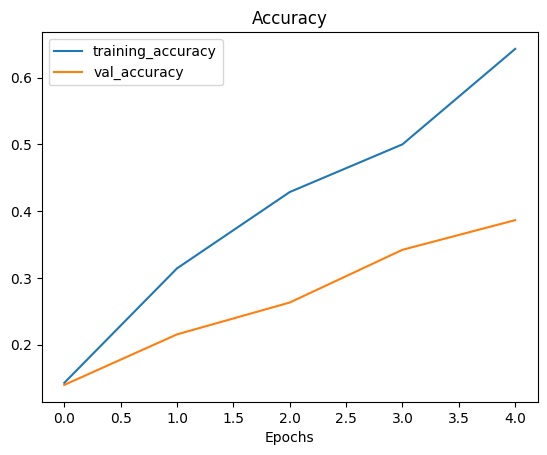

In [30]:
plot_loss_curves(history_1_percent)

## Model_2

In [31]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-05 13:19:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  41.6MB/s    in 4.6s    

2023-06-05 13:20:04 (35.3 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [32]:
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [33]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [34]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [35]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentations=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
])


In [36]:
input_shape=(224,224,3)

In [37]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,
                    name="Input layer")

x=data_augmentations(inputs)

x=base_model(x,training=False)#pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers dont get updated
#BatchNorm is the only layer that shouldn't be unfrozen during re-training
x=layers.GlobalAveragePooling2D()(x)

outputs=layers.Dense(10, activation='softmax',name='output_layer')(x)

model_2=keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.fit(train_data_10_percent,
            steps_per_epoch=len(train_data_10_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback('transfer_learning',
                                                                       experiment_name='10_percent_data_aug')])


                                 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230605-132009
Epoch 1/5
24/24 [==============================] - 23s 614ms/step - loss: 2.0004 - accuracy: 0.3400 - val_loss: 1.4467 - val_accuracy: 0.6595
Epoch 2/5
24/24 [==============================] - 13s 515ms/step - loss: 1.2976 - accuracy: 0.6747 - val_loss: 1.0109 - val_accuracy: 0.7730
Epoch 3/5
24/24 [==============================] - 16s 642ms/step - loss: 0.9990 - accuracy: 0.7600 - val_loss: 0.7715 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 15s 582ms/step - loss: 0.8299 - accuracy: 0.8107 - val_loss: 0.6664 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 12s 487ms/step - loss: 0.7339 - accuracy: 0.8080 - val_loss: 0.6320 - val_accuracy: 0.8438


In [38]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

### Creating a Model Checkpoint callback

The modelCheckpoint callback intermediately saves outr model( the full model or just the weights) during training. 

In [39]:
checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

#Create a modelCheckPoint Callback that saves the model's weights only

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=False,
                                                       save_weights_only=True,
                                                       save_freq='epoch', #Saves every Epoch
                                                       verbose=1
                                                       )

In [40]:
model_2.fit(train_data_10_percent,
            steps_per_epoch=len(train_data_10_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback('transfer_learning',
                                                                       experiment_name='10_percent_data_aug'),
                                           checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230605-132136
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.8373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 427ms/step - loss: 0.6612 - accuracy: 0.8373 - val_loss: 0.5673 - val_accuracy: 0.8618
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.6171 - accuracy: 0.8440
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 433ms/step - loss: 0.6171 - accuracy: 0.8440 - val_loss: 0.5675 - val_accuracy: 0.8520
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.5577 - accuracy: 0.8653
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 400ms/step - loss: 0.5577 - accuracy: 0.8653 - val_loss: 0.5481 - val_accuracy: 0.8536
E

In [41]:
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                      experiment_name="10_percent_data_aug"),
                                         checkpoint_callback ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230605-132248


Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.4692 - accuracy: 0.8893
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 441ms/step - loss: 0.4692 - accuracy: 0.8893 - val_loss: 0.5207 - val_accuracy: 0.8438
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.4375 - accuracy: 0.8893
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 393ms/step - loss: 0.4375 - accuracy: 0.8893 - val_loss: 0.4729 - val_accuracy: 0.8717
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.4241 - accuracy: 0.8947
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 524ms/step - loss: 0.4241 - accuracy: 0.8947 - val_loss: 0.4754 - val_accuracy: 0.8734
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.3911 - accuracy: 0.

In [42]:
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4488 - accuracy: 0.8632


In [43]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 68ms/step - loss: 0.5596 - accuracy: 0.8616


[0.5595560669898987, 0.8615999817848206]

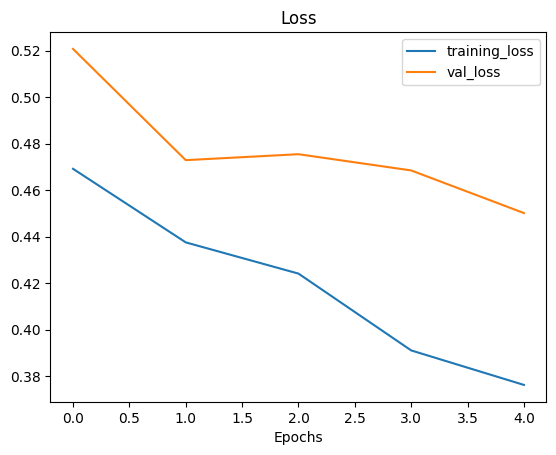

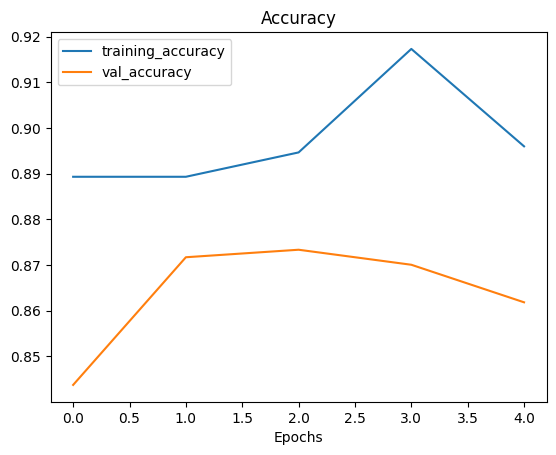

In [44]:
plot_loss_curves(history_10_percent_data_aug)

In [45]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

### Loading in checkpointed weights

Returns a model to a specific checkpoint

In [46]:
#load in saved model weights and evaluate

model_2.load_weights(checkpoint_path)

In [47]:
#Evaluate the model with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 68ms/step - loss: 0.4488 - accuracy: 0.8632


In [48]:
#If the results from our previouly evaluated model match, then everything is fine and working
results_10_percent_data_aug==loaded_weights_model_results

False

In [49]:
loaded_weights_model_results,results_10_percent_data_aug

([0.44880589842796326, 0.8632000088691711],
 [0.44880586862564087, 0.8632000088691711])

In [50]:
# precision of the numbers stored is different
#Check to see if loaded model results are very close to the previous non loaded results

import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

### Model 3 - Fine tuning an existing on 10% of the data

Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
Unfreeze the few layers towards the end of the odel/layers

In [52]:
#load the saved checkpoint
model_2.layers

In [53]:
for layers in model_2.layers:
  print(layer, layer.trainable)

<keras.layers.core.activation.Activation object at 0x7ff8988cf0a0> False
<keras.layers.core.activation.Activation object at 0x7ff8988cf0a0> False
<keras.layers.core.activation.Activation object at 0x7ff8988cf0a0> False
<keras.layers.core.activation.Activation object at 0x7ff8988cf0a0> False
<keras.layers.core.activation.Activation object at 0x7ff8988cf0a0> False


In [58]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [59]:
#how many  trainable variables in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [61]:
#To begin fine tuning , let's start by setting the last 10 layers of our base model to trainable=True

base_model.trainable=True

#Freeze all layers except last 10
for layer in base_model.layers[:-10]:
  
  layer.trainable=False

In [63]:
#Recompile the entire model everytime we make a change

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [66]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

 We should always keep the learning rate as low as we can as it can result in overitting. It should always be lowered by 10X

In [67]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [68]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 rescaling_5 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [69]:
print(len(model_2.trainable_variables))

12


In [70]:
# Fine tune for another 5 epochs
fine_tune_epochs=initial_epochs +5
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                       epochs=fine_tune_epochs,
                                       steps_per_epoch=len(train_data_10_percent),
                                       validation_data=test_data,
                                       validation_steps=int(0.25*len(test_data)),
                                       initial_epoch=history_10_percent_data_aug.epoch[-1],
                                       callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                              experiment_name="10_percent_fine_tuning")])# Start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tuning/20230605-134714
Epoch 5/10
24/24 [==============================] - 24s 469ms/step - loss: 0.3528 - accuracy: 0.9040 - val_loss: 0.4435 - val_accuracy: 0.8586
Epoch 6/10
24/24 [==============================] - 9s 364ms/step - loss: 0.2695 - accuracy: 0.9240 - val_loss: 0.4104 - val_accuracy: 0.8717
Epoch 7/10
24/24 [==============================] - 9s 339ms/step - loss: 0.2336 - accuracy: 0.9307 - val_loss: 0.3900 - val_accuracy: 0.8849
Epoch 8/10
24/24 [==============================] - 8s 328ms/step - loss: 0.2122 - accuracy: 0.9413 - val_loss: 0.4507 - val_accuracy: 0.8586
Epoch 9/10
24/24 [==============================] - 10s 394ms/step - loss: 0.1917 - accuracy: 0.9493 - val_loss: 0.4353 - val_accuracy: 0.8717
Epoch 10/10
24/24 [==============================] - 9s 349ms/step - loss: 0.1817 - accuracy: 0.9480 - val_loss: 0.4030 - val_accuracy: 0.8783


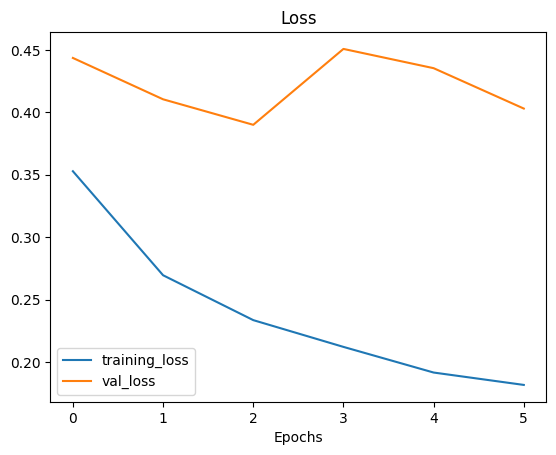

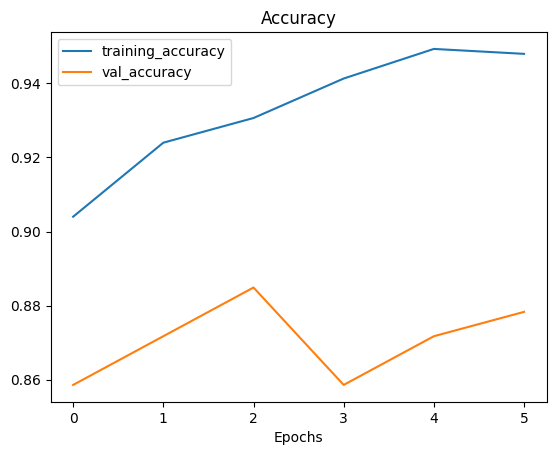

In [71]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [73]:
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 7s 68ms/step - loss: 0.4004 - accuracy: 0.8660


In [79]:
#Create a function to compare training histories
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares 2 tensorflow history objects
  """

  acc=original_history.history['accuracy']
  loss=original_history.history['loss']

  val_acc=original_history.history['val_accuracy']
  val_loss=original_history.history['val_loss']

  #Combine Original History 
  total_acc=acc+new_history.history['accuracy']
  total_loss=loss+new_history.history['loss']

  total_val_acc=val_acc+new_history.history['val_accuracy']
  total_val_loss=val_loss+new_history.history['val_loss']

  #Make Plots
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label= "training Accuracy")
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")

  plt.legend(loc="lower right")
  plt.title("Training Validation accuracy")

  #Make Plots for loss
  
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss, label= "training Loss")
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label="Start Fine Tuning")

  plt.legend(loc="lower right")
  plt.title("Training Validation loss")
  

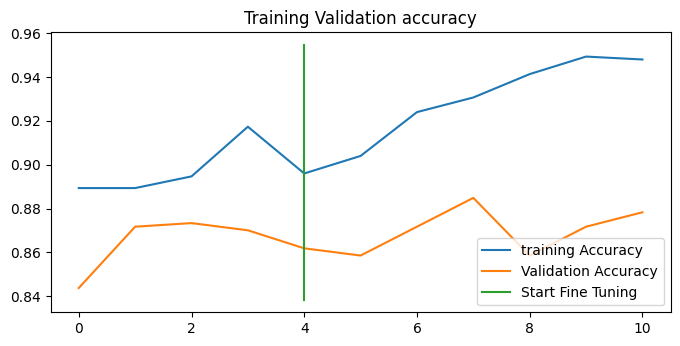

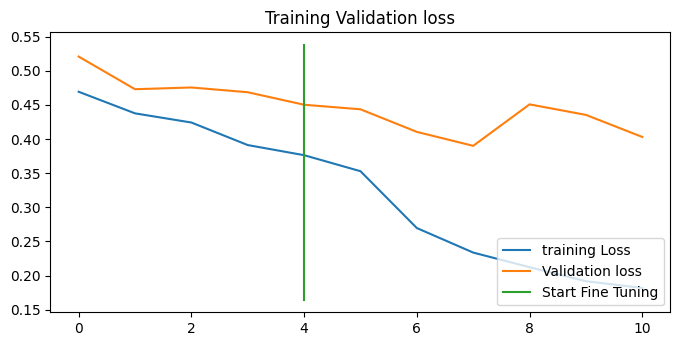

In [80]:
compare_history(history_10_percent_data_aug,
                history_fine_10_percent_data_aug,
                initial_epochs=5)